## Benchmark halo.

In [ ]:
from shared.preface import *
import commah

sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_1Halo'

# Box parameters and arrays.
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)
DM_mass = box_setup['Content']['DM Mass [Msun]']*Msun
nums_snaps = np.load(f'{sim_dir}/nums_snaps.npy')
zeds_snaps = np.load(f'{sim_dir}/zeds_snaps.npy')

FCT_h = box_setup['Cosmology']['h']
FCT_H0 = FCT_h*100*km/s/Mpc
FCT_Omega_M = box_setup['Cosmology']['Omega_M']
FCT_Omega_L = box_setup['Cosmology']['Omega_L']

@nb.njit
def rho_crit(z):
    """Critical density of the universe as a function of redshift, assuming
    matter domination, only Omega_m and Omega_Lambda in Friedmann equation. See 
    notes for derivation.

    Args:
        z (array): redshift

    Returns:
        array: critical density at redshift z
    """    
    
    H_squared = FCT_H0**2 * (FCT_Omega_M*(1.+z)**3 + FCT_Omega_L) 
    rho_crit = 3.*H_squared / (8.*Pi*G)

    return np.float64(rho_crit)


def halo_sample_z(z, snap, Mvir_z0, DM_mass, out_dir):

    # Get the DM halo mass (and the number of DM particles for sample).
    commah_output = commah.run('Planck13', zi=0, Mi=Mvir_z0, z=z)
    Mz = commah_output['Mz'][0,0]*Msun
    num_DM = math.floor(Mz / DM_mass)

    # Get the concentration of the halo.
    c_200 = commah_output['c'][0,0]

    # Calculate R_200 and R_s ("virial" radius and scale radius).
    R_200 = np.power(Mz / (200*rho_crit(z)*4/3*Pi), 1./3.)
    R_s = R_200 / c_200

    # Construct projection function.
    def Proj(r, r_s, norm):
        x = r/r_s
        return (np.log(1+x) - (x/(1+x)))/norm

    # Construct inverse function. Needs to be without numerical units.
    f_200 = np.log(1+c_200) - (c_200/(1+c_200))
    invf = inversefunc(Proj, args=(R_s/kpc, f_200))  

    # Sample uniformly between [0,1] and project to corresponding radius.
    sample = np.sort(np.random.uniform(size=num_DM))
    r_sample = invf(sample)

    # Sample for angles and convert to cartesian DM_coords.
    phis = np.random.uniform(0, 2*Pi, num_DM)  # uniform [0,2pi)
    cos_thetas = 2.*np.random.uniform(0, 1, num_DM) - 1  # uniform [-1,1)

    # Convert to cartesian coordinates.
    x = r_sample*np.cos(phis)*np.sqrt(1. - cos_thetas**2)
    y = r_sample*np.sin(phis)*np.sqrt(1. - cos_thetas**2)
    z = r_sample*cos_thetas
    coords = np.column_stack((x,y,z))

    np.save(f'{out_dir}/benchmark_halo_snap_{snap}.npy', coords)


benchmark_outdir = f'L025N752/DMONLY/SigmaConstant00/benchmark_halo_files'
if not os.path.exists(benchmark_outdir):
    os.makedirs(benchmark_outdir)

with ProcessPoolExecutor(24) as ex:
    ex.map(
        halo_sample_z, zeds_snaps, nums_snaps,
        repeat(Mvir_MW/Msun), repeat(DM_mass), repeat(benchmark_outdir)
    )

In [ ]:
benchmark_DM = np.array([
    len(np.load(f'{benchmark_outdir}/benchmark_halo_snap_{num}.npy')) 
    for num in nums_snaps
])

print(np.log10(Mvir_MW/Msun), np.log10(DM_mass*benchmark_DM[-1]/Msun))

nums_proxy = np.arange(12, 36+1)
plt.plot(nums_proxy, benchmark_DM); plt.show()

## Run scripts.

### all_sky sim type tests.

In [ ]:
!python make_simulation_parameters.py \
--sim_dir L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
--sim_type all_sky \
--healpix_nside 2 \
--nu_mass_start 0.01 \
--nu_mass_stop 0.3 \
--nu_mass_num 100 \
--nu_sim_mass 0.3 \
--p_start 0.01 \
--p_stop 400 \
--p_num 10_000 \
--init_x_dis 8.5 \
--z_int_shift 0.1 \
--z_int_stop 4 \
--z_int_num 100 \
--int_solver RK23 \
--CPUs_precalculations 128 \
--CPUs_simulations 128 \
--memory_limit_GB 224 \
--DM_in_cell_limit 10_000

In [ ]:
from shared.preface import *

arr = np.load('L025N752/DMONLY/SigmaConstant00/low_res_all_sky/initial_velocities.npy')
print(arr.itemsize*arr.size/1e6)
print(arr.shape)

In [ ]:
print(os.getcwd())

In [ ]:
!python simulation_analytical.py \
-d L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
-st all_sky \
--MW_halo \
--no-VC_halo \
--no-AG_halo

In [ ]:
from shared.preface import *
arr = np.load('L025N752/DMONLY/SigmaConstant00/low_res_all_sky/number_densities_analytical_all_sky.npy')
print(arr.shape)

In [ ]:
!python simulation_numerical.py \
-d L025N752/DMONLY/SigmaConstant00/low_res_all_sky \
-st all_sky \
-mg 12.0 \
-mr 0.6 \
-hn 1

### single_halos & benchmark sim type tests.

In [ ]:
!python simulation_analytical.py -d L025N752/DMONLY/SigmaConstant00/low_res_1Halo_plus_benchmark -st single_halos --MW_halo --no-VC_halo --no-AG_halo

In [ ]:
!python simulation_numerical.py -d L025N752/DMONLY/SigmaConstant00/high_res_1Halo -st single_halos -mg 12.0 -mr 0.6 -hn 1

## Load, transform and plot simulation outputs.

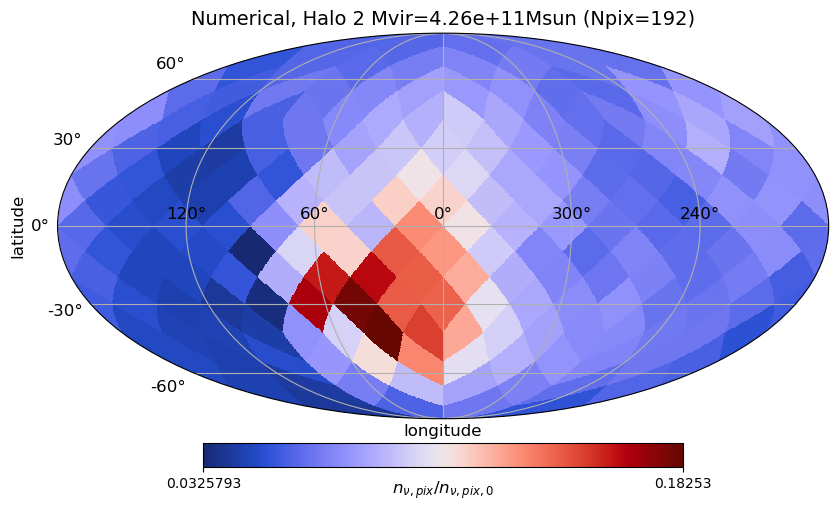

In [37]:
from shared.preface import *
from shared.shared_functions import *

class analyze_simulation_outputs(object):

    def __init__(self, sim_dir, objects, sim_type):

        # Required:
        self.sim_dir = sim_dir
        self.objects = objects
        self.sim_type = sim_type
        
        self.fig_dir = f'figures/{sim_dir}'
        if not os.path.exists(self.fig_dir):
            os.makedirs(self.fig_dir)


        # Neccessary arrays.
        self.mrange = np.load(f'{self.sim_dir}/neutrino_massrange_eV.npy')*eV
        self.mpicks = np.array([0.01, 0.05, 0.1, 0.3])

        if self.sim_type == 'single_halos':

            if 'NFW_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_numerical_benchmark_halo_batch*.npy'
                )
                
                self.vectors_benchmark = []
                for batch_path in batch_paths:
                    self.vectors_benchmark.append(np.load(batch_path))
                self.vectors_benchmark = np.squeeze(
                    np.array(self.vectors_benchmark)
                )
                self.vectors_benchmark = np.array(self.vectors_benchmark)

                self.etas_benchmark = np.load(
                    f'{self.sim_dir}/number_densities_numerical_benchmark_halo.npy'
                )/N0


            if 'box_halos' in self.objects:
                
                self.etas_numerical = []
                self.vectors_numerical = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1): 
                    
                    # Find all batch paths belonging to current halo.
                    batch_paths = glob.glob(
                        f'{self.sim_dir}/neutrino_vectors_numerical_halo{halo}_batch*.npy'
                    )

                    # Concatenate all vector batches into one array.
                    vectors_halo = []
                    for batch_path in batch_paths:
                        vectors_halo.append(np.load(batch_path))
                    vectors_halo = np.squeeze(np.array(vectors_halo))

                    # Append vectors.
                    self.vectors_numerical.append(vectors_halo)

                    # Append overdensities.
                    self.etas_numerical.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}.npy'
                        )/N0
                    )

                self.etas_numerical = np.array(self.etas_numerical)
                self.vectors_numerical = np.array(self.vectors_numerical)


            if 'analytical_halo' in self.objects:

                batch_paths = glob.glob(
                    f'{self.sim_dir}/neutrino_vectors_analytical_batch*.npy'
                )
                
                self.vectors_analytical = []
                for batch_path in batch_paths:
                    self.vectors_analytical.append(np.load(batch_path))
                self.vectors_analytical = np.squeeze(
                    np.array(self.vectors_analytical)
                )
                self.vectors_analytical = np.array(self.vectors_analytical)

                self.etas_analytical = np.load(
                    f'{self.sim_dir}/number_densities_analytical.npy'
                )/N0


        elif self.sim_type == 'all_sky':

            if 'box_halos' in self.objects:

                self.number_densities_numerical_all_sky = []

                halo_num = len(np.load(
                    glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
                ))

                for halo in range(1, halo_num+1):
                    
                    # Append overdensities.
                    self.number_densities_numerical_all_sky.append(
                        np.load(
                            f'{self.sim_dir}/number_densities_numerical_halo{halo}_all_sky.npy'
                        )
                    )

                self.number_densities_numerical_all_sky = np.array(
                    self.number_densities_numerical_all_sky
                )


            if 'analytical_halo' in self.objects:

                self.number_densities_analytical_all_sky = np.load(
                    f'{self.sim_dir}/number_densities_analytical_all_sky.npy'
                )


    def plot_all_sky_map(self, nu_mass_eV, sim_method, halo=None):

        savefig_args = dict(
            bbox_inches='tight'
        )
        nu_mass_idx = (np.abs(self.mrange-nu_mass_eV)).argmin()

        with open(f'{self.sim_dir}/sim_parameters.yaml', 'r') as file:
            sim_setup = yaml.safe_load(file)

        Nside = sim_setup['Nside']
        Npix = sim_setup['Npix']
        pix_sr = sim_setup['pix_sr']
        N0_pix = N0/Npix

        if sim_method == 'analytical':

            dens_nu = self.number_densities_analytical_all_sky[:,nu_mass_idx]
            etas_nu = dens_nu*(pix_sr/4*Pi)/N0_pix

            healpix_map = etas_nu

            hp.newvisufunc.projview(
                healpix_map,
                coord=["G"],
                title=f'Analytical (Npix={Npix}, {nu_mass_eV}eV)',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                # cbar_ticks=[],
                # show_tickmarkers=True,
            )

            plt.savefig(
                f'{self.fig_dir}/all_sky_map_analytical_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map

        if sim_method == 'numerical':


            from astropy import units as u
            from astropy.coordinates import SkyCoord

            def spherical_to_galactic(polar_angles, azimuthal_angles, unit='radian'):
                """
                Convert spherical coordinate angles (polar and azimuthal angles) to
                galactic latitude and longitude.

                Parameters
                ----------
                polar_angles : numpy.array
                    Array of polar angles (theta).
                azimuthal_angles : numpy.array
                    Array of azimuthal angles (phi).
                unit : str, optional
                    Unit of the input angles, either 'radian' (default) or 'degree'.

                Returns
                -------
                numpy.array
                    Array of galactic latitude and longitude.
                """

                if unit == 'radian':
                    # Convert angles from radians to degrees
                    polar_degrees = np.rad2deg(polar_angles)
                    azimuthal_degrees = np.rad2deg(azimuthal_angles)
                elif unit == 'degree':
                    polar_degrees = polar_angles
                    azimuthal_degrees = azimuthal_angles
                else:
                    raise ValueError("Invalid unit. It must be either 'radian' or 'degree'.")

                # Convert to equatorial coordinates (RA, Dec)
                ra = azimuthal_degrees
                dec = 90 - polar_degrees

                # Create SkyCoord object for the equatorial coordinates
                equatorial_coords = SkyCoord(ra=ra, dec=dec, frame='icrs', unit='deg')

                # Convert to galactic coordinates (l, b)
                galactic_coords = equatorial_coords.transform_to('galactic')

                # Get galactic latitude and longitude
                galactic_latitude = galactic_coords.b.deg
                galactic_longitude = galactic_coords.l.deg

                # Combine galactic latitude and longitude into a single array
                galactic_coordinates = np.vstack((galactic_latitude, galactic_longitude)).T

                return galactic_coordinates



            halo_params = np.load(
                glob.glob(f'{self.sim_dir}/halo*params.npy')[0]
            )
            Mvir = halo_params[halo-1,1]
            
            # Initial pixel array.
            dens_nu = self.number_densities_numerical_all_sky[...,nu_mass_idx]
            etas_nu = dens_nu*(pix_sr/4*Pi)/N0_pix
            healpix_map = etas_nu[halo-1,:]
            
            # Angles from initialization.
            old_angles = np.load(f'{self.sim_dir}/all_sky_angles.npy')
            phis, thetas = old_angles[:, 0], old_angles[:, 1]

            # gal_coords = spherical_to_galactic(thetas, phis)
            # glat_deg, glon_deg = gal_coords[:, 0], gal_coords[:, 1]

            # Convert old angles to pixel indices.
            init_indices = hp.ang2pix(Nside, thetas, phis)

            # Determine new angles, which are galactic latitude and longitude.
            glat = Pi/2. - thetas
            # glat = thetas - Pi/2.

            # phi_cond1 = (phis <= Pi)
            # phis[phi_cond1] = Pi - phis[phi_cond1]
            # phis[phi_cond1] = phis[phi_cond1] - Pi
            # phis[phi_cond1] += Pi

            # phi_cond2 = (phis > Pi) & (phis <= 2*Pi)
            # phis[phi_cond2] = 3*Pi - phis[phi_cond2]
            # phis[phi_cond2] = phis[phi_cond2] - 3*Pi
            # phis[phi_cond2] -= Pi
            # glon = Pi/2 - phis

            # Convert new angles to pixel indices.
            hp_thetas, hp_phis = np.rad2deg(glon), np.rad2deg(glat)
            # hp_thetas, hp_phis = glon_deg, glat_deg
            new_indices = hp.ang2pix(Nside, hp_thetas, hp_phis, lonlat=True)

            # Initialize an empty array for the rearranged Healpix values
            new_healpix_map = np.zeros_like(healpix_map)

            # Rearrange the Healpix values based on the new pixel indices
            for i, old_index in enumerate(init_indices):
                new_healpix_map[new_indices[i]] = healpix_map[old_index]

            # hp.mollview(healpix_map, cmap=cc.cm.CET_D1A)

            hp.newvisufunc.projview(
                new_healpix_map,
                coord=['G'],
                title=f'Numerical, Halo {halo} Mvir={10**Mvir:.2e}Msun (Npix={Npix})',
                unit=r'$n_{\nu, pix} / n_{\nu, pix, 0}$',
                cmap=cc.cm.CET_D1A,
                graticule=True,
                graticule_labels=True,
                xlabel="longitude",
                ylabel="latitude",
                cb_orientation="horizontal",
                projection_type="mollweide",
                flip='astro'
                # cbar_ticks=[],
                # show_tickmarkers=True,
            )

            plt.savefig(
                f'{self.fig_dir}/all_sky_map_numerical_halo{halo}_{nu_mass_eV}eV.pdf', 
                **savefig_args
            )
            plt.show()
            plt.close()

            return healpix_map


    def plot_project_DM_healpix(self, halo, DM_pos_orig, Obs_pos_orig, Nside):

        def rotation_matrix(theta1, theta2, theta3):
            """In order "zyx", angles in radian. """

            c1 = np.cos(theta1)
            s1 = np.sin(theta1)
            c2 = np.cos(theta2)
            s2 = np.sin(theta2)
            c3 = np.cos(theta3)
            s3 = np.sin(theta3)

            matrix = np.array(
                [[c1*c2, c1*s2*s3-c3*s1, s1*s3+c1*c3*s2],
                [c2*s1, c1*c3+s1*s2*s3, c3*s1*s2-c1*s3],
                [-s2, c2*s3, c2*c3]]
            )

            return matrix


        # Calculate the Euler angles, to match frame of Earth. This will be the 
        # new frame in which DM particles get projected to an all sky map.
        zAngle = np.arctan2(Obs_pos_orig[1], Obs_pos_orig[0])
        yAngle = np.arctan2(Obs_pos_orig[2], np.linalg.norm(Obs_pos_orig[:2]))
        ic(zAngle)
        ic(yAngle)

        # note: Rotation (-Pi,Pi,0) in order zyx will put Obs_pos_orig at 
        # note: (x,-y,-z) in this newly rotated (earths) frame.
        # rot_mat = rotation_matrix(-Pi, Pi, 0)
        rot_mat = rotation_matrix(-zAngle, yAngle, 0)
        Obs_orig_in_rot_frame = np.matmul(rot_mat, Obs_pos_orig)

        # note: The rotation -(-Pi,Pi,0) in order zyx will place rotated earth 
        # note: on (x,y,z) coords. in original frame (used in sims). 
        # rot_mat_inverse = rotation_matrix(Pi, -Pi, 0)
        rot_mat_inverse = rotation_matrix(zAngle, -yAngle, 0)
        Obs_rot_in_orig_frame = np.matmul(rot_mat_inverse, Obs_pos_orig)

        # Dark matter positions in observer frame.
        DM_orig_in_rot_frame = np.matmul(rot_mat, DM_pos_orig.T).T

        # Dark matter positions centered on observer location.
        DM_obs_cent = DM_orig_in_rot_frame - Obs_pos_orig

        # Dark matter line-of-sight distance from observer.
        DM_los_dis = np.sqrt(np.sum(DM_obs_cent**2, axis=-1))

        # Dark matter distance to observer in projected XY-plane only.
        DM_proj_XY_plane_dis = np.sqrt(np.sum(DM_obs_cent[:,:2]**2, axis=-1))

        # Obs distance from halo center (this is just the distance on x-axis).
        Obs_dis = np.sqrt(np.sum(Obs_pos_orig**2, axis=-1))

        # Galactic latitude and longitude of DM as seen from Earth when looking 
        # at halo center. 
        # note: 
        # arctan2 returns [-pi,pi] range, but healpy convention is [0,2pi] for 
        # longitude, so do pi+arctan2.
        glat = np.arctan2(DM_obs_cent[:,2], DM_proj_XY_plane_dis)
        glon = Pi + np.arctan2(DM_obs_cent[:,1], DM_obs_cent[:,0])
        hp_thetas, hp_phis = np.rad2deg(glon), np.rad2deg(glat)

        np.save('angles.npy', np.transpose((hp_phis, hp_thetas)))

        # Convert angles to pixel indices using ang2pix.
        # note:
        # for lonlat=True, the "theta" for healpy is (galactic) longitude and 
        # the "phi" is latitude.
        pixel_indices = hp.ang2pix(Nside, hp_thetas, hp_phis, lonlat=True)

        # Create a Healpix map and increment the corresponding pixels.
        healpix_map = np.zeros(hp.nside2npix(Nside))
        np.add.at(healpix_map, pixel_indices, 1)

        hp.newvisufunc.projview(
            healpix_map,
            coord=['G'],
            title=f'All-sky view of DM content as seen from Earth',
            unit=r'DM particles in pixel',
            cmap='Purples',
            graticule=True,
            graticule_labels=True,
            xlabel="longitude",
            ylabel="latitude",
            cb_orientation="horizontal",
            projection_type="mollweide",
            flip='astro',
            # cbar_ticks=[],
            show_tickmarkers=True,

        )
        plt.show()

        savefig_args = dict(
            bbox_inches='tight'
        )
        plt.savefig(
            f'{self.fig_dir}/DM_projected_healpix_halo{halo}.pdf', 
            **savefig_args
        )



### Specify simulation directory and objects therein to analyze.
sim_dir = f'L025N752/DMONLY/SigmaConstant00/high_res_all_sky'
objects = (
    # 'NFW_halo', 
    'box_halos', 
    # 'analytical_halo'
)

### Initialize the class, which has all simulation outputs and plotting scripts.
Analysis = analyze_simulation_outputs(
    sim_dir = sim_dir,
    objects = objects,
    sim_type = 'all_sky'
)

### Generate plots. Output in figures/{sim_dir}. ###
### -------------------------------------------- ###

# Analysis.plot_overdensity_band(plot_ylims=(3*1e-4,1e1))
# Analysis.plot_overdensity_evolution(plot_ylims=(1e-4,1e1))
# Analysis.plot_phase_space(mass_gauge=12.0, mass_range=0.6, most_likely=True)
# Analysis.plot_density_profiles(mass_gauge=12.0, mass_range=0.6, NFW_orig=True)

# healpix_map = Analysis.plot_all_sky_map(
#     nu_mass_eV=0.3, sim_method='analytical', halo=None
# )
for i in range(1,4):
    healpix_map = Analysis.plot_all_sky_map(
        nu_mass_eV=0.3, sim_method='numerical', halo=i
    )


### Load a DM halo. ###
### --------------- ###
halo_idx = 2
#? select halo by loading snaps_progID for loading DM just like in sim.
'''
with open(f'{sim_dir}/box_parameters.yaml', 'r') as file:
    box_setup = yaml.safe_load(file)

box_file_dir = box_setup['File Paths']['Box File Directory']

halo_batch_IDs = np.load(
    glob.glob(f'{sim_dir}/halo_batch*indices.npy')[0]
)
halo_ID = int(halo_batch_IDs[halo_idx])

DM_pos_orig, DM_com = read_DM_halo_index(
    '0036', halo_ID, '', box_file_dir, '', direct=True
)
# '''
### --------------- ###

DM_pos_NFW = np.load('L025N752/DMONLY/SigmaConstant00/benchmark_halo_files/benchmark_halo_snap_0036.npy')

# DM_test = np.ones((1,3))*np.array([10,0,0])
with open(f'{sim_dir}/sim_parameters.yaml', 'r') as file:
    sim_setup = yaml.safe_load(file)

init_dis = sim_setup['initial_haloGC_distance']
init_xyz = np.array([init_dis, 1e-3, 1e-3])

# Analysis.plot_project_DM_healpix(
#     halo=halo_idx, DM_pos_orig=DM_pos_NFW, Obs_pos_orig=init_xyz, Nside=2**2
# )

In [20]:
angs = np.load('angles.npy')
for a in angs[:20]:
    val = (a)
    print(f'{val[0]:.2f} {val[1]:.2f}')

-0.07 359.89
-0.10 0.29
-0.03 359.66
0.36 359.86
0.16 0.51
0.04 359.48
0.45 359.53
0.11 359.49
-0.69 359.51
-0.55 359.90
-0.69 359.52
0.18 0.98
-0.13 359.01
-0.99 0.35
1.11 359.97
-0.59 359.11
0.89 0.78
-0.54 358.95
-0.42 359.49
-0.19 1.17


In [7]:
angs = np.load('L025N752/DMONLY/SigmaConstant00/high_res_all_sky/all_sky_angles.npy')
print(np.rad2deg(angs))

[[ 45.          11.71585239]
 [135.          11.71585239]
 [225.          11.71585239]
 [315.          11.71585239]
 [ 22.5         23.55646431]
 [ 67.5         23.55646431]
 [112.5         23.55646431]
 [157.5         23.55646431]
 [202.5         23.55646431]
 [247.5         23.55646431]
 [292.5         23.55646431]
 [337.5         23.55646431]
 [ 15.          35.6590877 ]
 [ 45.          35.6590877 ]
 [ 75.          35.6590877 ]
 [105.          35.6590877 ]
 [135.          35.6590877 ]
 [165.          35.6590877 ]
 [195.          35.6590877 ]
 [225.          35.6590877 ]
 [255.          35.6590877 ]
 [285.          35.6590877 ]
 [315.          35.6590877 ]
 [345.          35.6590877 ]
 [ 11.25        48.1896851 ]
 [ 33.75        48.1896851 ]
 [ 56.25        48.1896851 ]
 [ 78.75        48.1896851 ]
 [101.25        48.1896851 ]
 [123.75        48.1896851 ]
 [146.25        48.1896851 ]
 [168.75        48.1896851 ]
 [191.25        48.1896851 ]
 [213.75        48.1896851 ]
 [236.25      

In [32]:
Nside = 2**2
Npix = 12 * Nside**2  # Number of pixels
pix_sr = (4*np.pi)/Npix  # Pixel size  [sr]

theta_angles, phi_angles = np.array(
    hp.pixelfunc.pix2ang(Nside, np.arange(Npix))
)
print(np.round(np.rad2deg(Pi/2. - theta_angles),1))
# print(np.rad2deg(phi_angles))

# phi_angles, theta_angles = np.array(
#     hp.pixelfunc.pix2ang(Nside, np.arange(Npix), lonlat=True)
# )
# print(theta_angles)z
# print(phi_angles)

[ 78.3  78.3  78.3  78.3  66.4  66.4  66.4  66.4  66.4  66.4  66.4  66.4
  54.3  54.3  54.3  54.3  54.3  54.3  54.3  54.3  54.3  54.3  54.3  54.3
  41.8  41.8  41.8  41.8  41.8  41.8  41.8  41.8  41.8  41.8  41.8  41.8
  41.8  41.8  41.8  41.8  30.   30.   30.   30.   30.   30.   30.   30.
  30.   30.   30.   30.   30.   30.   30.   30.   19.5  19.5  19.5  19.5
  19.5  19.5  19.5  19.5  19.5  19.5  19.5  19.5  19.5  19.5  19.5  19.5
   9.6   9.6   9.6   9.6   9.6   9.6   9.6   9.6   9.6   9.6   9.6   9.6
   9.6   9.6   9.6   9.6   0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.   -9.6  -9.6  -9.6  -9.6
  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6  -9.6
 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5 -19.5
 -19.5 -19.5 -19.5 -19.5 -30.  -30.  -30.  -30.  -30.  -30.  -30.  -30.
 -30.  -30.  -30.  -30.  -30.  -30.  -30.  -30.  -41.8 -41.8 -41.8 -41.8
 -41.8 -41.8 -41.8 -41.8 -41.8 -41.8 -41.8 -41.8 -41.8

In [26]:
from shared.preface import *

pos = np.array([16, 0, 8])
ref = np.array([8, 0, 0])
pos -= ref
# theta = np.arccos(np.linalg.norm(pos[:2])/np.linalg.norm(pos))
theta = np.arctan2(pos[2],np.linalg.norm(pos[:2]))
phi = Pi + np.arctan2(pos[1],pos[0])
ic(np.rad2deg(theta))
ic(np.rad2deg(phi))

ic| np.rad2deg(theta): 45.0
ic| np.rad2deg(phi): 180.0


180.0

In [ ]:
def rotate_healpix_map(pixel_array, rot_angles):

    # Create a rotator object
    r = hp.Rotator(rot=rot_angles, deg=False, inv=True, eulertype='ZYX')

    # Rotate the pixel array
    healpix_map_rotated = r.rotate_map_pixel(pixel_array)

    hp.newvisufunc.projview(
        healpix_map_rotated,
        coord=['G'],
        title=f'All-sky view of DM content as seen from Earth',
        unit=r'DM particles in pixel',
        cmap=cc.cm.CET_D1A,
        graticule=True,
        graticule_labels=True,
        xlabel="longitude",
        ylabel="latitude",
        cb_orientation="horizontal",
        projection_type="mollweide",
        flip='astro',
        # cbar_ticks=[],
        show_tickmarkers=True,

    )

    plt.show()

    return healpix_map_rotated


rot = Pi/4
rot_angles = (-rot, rot, 0)
pixel_array_rotated = rotate_healpix_map(healpix_map, rot_angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cond = ()
x_DM, y_DM, z_DM = DM_pos_orig[:,0], DM_pos_orig[:,1], DM_pos_orig[:,2]
cut = 1
x, y, z = x_DM[1::cut], y_DM[1::cut], z_DM[1::cut]
ax.scatter(x, y, z, alpha=1, c='blueviolet', s=0.0001, label='DM particles')
# ax.scatter(0.465, 0.025, 8.48, c='green', s=100, label='Earth')
axlim = 20
# ax.set_xlabel('x-axis?')
ax.set_xlim(-axlim, axlim)
ax.set_ylim(-axlim, axlim)
ax.set_zlim(-axlim, axlim)
ax.view_init(elev=0, azim=0)
plt.legend(loc='upper right')
plt.show()

In [ ]:
from shared.preface import *
from shared.shared_functions import *


reso = 'low'
init_vels = np.load(
    f'L025N752/DMONLY/SigmaConstant00/{reso}_res_all_sky/initial_velocities.npy'
)
ic(init_vels.shape)

def vel_arrows(
    pos_coords, vel_coords
):

    # Coordinates in position space.
    pX = pos_coords[:,0]
    pY = pos_coords[:,1]
    pZ = pos_coords[:,2]

    # Coordinates in velocity space.

    vX = vel_coords[:,0]
    vY = vel_coords[:,1]
    vZ = vel_coords[:,2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    start, stop = 0, -1 
    # start, stop = 100, -1 
    ax.quiver(
        pX[start:stop], pY[start:stop], pZ[start:stop], 
        vX[start:stop], vY[start:stop], vZ[start:stop], 
        length=0.05, normalize=True
    )
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    ax.view_init(elev=90, azim=0)

    plt.show()


vel_coords = init_vels[:,0,:]
vel_coords = vel_coords[vel_coords[...,0] > 0.]
pos_coords = np.zeros((len(vel_coords),3))
vel_arrows(pos_coords, vel_coords)